# Lecture 10 時系列分析

- 「データサイエンス教本：橋本」とは少し、式の形とかアプローチが異なることに注意
  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import io
import requests
import statsmodels.api as sm


## 対数差分変換

金融の分野では、元の価格推移のデータを対数変換したのち差分変換する対数差分変換がしばしば行われ、変化後のデータは「対数収益率」とよばれます。 対数収益率を用いることには、「100円の銘柄が1円値上がりする」ことと「1000円の銘柄が1円値上がりする」ことの不平等さを解消できることなど、様々なメリットがあります。

In [2]:

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

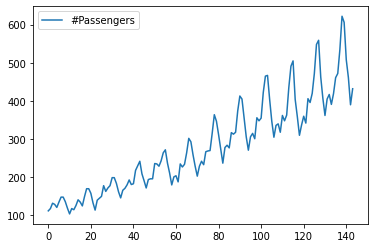

In [3]:
df.plot()

##### 差分変換

差分変換についてですが、pandasのdiff()メソッドを使うことができます。 引数periodsは差分を取るラグを表しています。 実行結果を見ると、AirPassengersのトレンドは除去され、平均に関する非定常性を解消できたことが伺えます。

<AxesSubplot:>

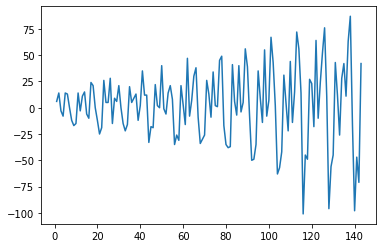

In [4]:
Passengers_diff = df["#Passengers"].diff(periods = 1)
Passengers_diff.plot()

##### 対数変換
次に対数変換を行ってみましょう。 対数をとるには数値計算モジュールnumpyのlog()を使います。 なお、対数の底はネイピア数e です。 対数変換後の図ともとの図を見比べると、トレンドに比例したバラツキの増加が解消されたことがわかります。

In [5]:
Passengers_log = np.log(df["#Passengers"])
Passengers_log.head()

0    4.718499
1    4.770685
2    4.882802
3    4.859812
4    4.795791
Name: #Passengers, dtype: float64

<AxesSubplot:>

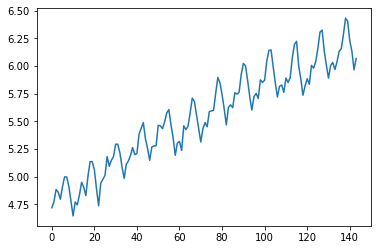

In [21]:
Passengers_log.plot()

##### 対数変換と差分変換を組み合わせた対数差分
対数変換と差分変換を組み合わせた対数差分の例を示します。 先ほど作成したPassengers_logを再利用し、差分をとってみましょう。 周期性が残っているものの、定常性の条件のうち、平均と分散に関するものが解消できたことが伺えます。

<AxesSubplot:>

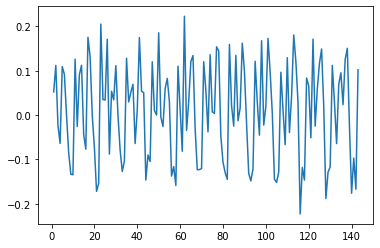

In [6]:
Passengers_log_diff = Passengers_log.diff(periods = 1)
Passengers_log_diff.plot()

##### 周期差分
周期を取り除くために、Passengers_logに対しperiods = 12として季節差分を行ってみましょう。 季節周期がなくなり、前年差が残ったことになります。

<AxesSubplot:>

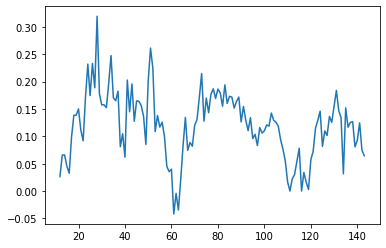

In [7]:
Passengers_sdiff = Passengers_log.diff(periods = 12)
Passengers_sdiff.plot()

さらにもう一度ラグ1の差分をとると、見た目が大分定常らしくなりました

<AxesSubplot:>

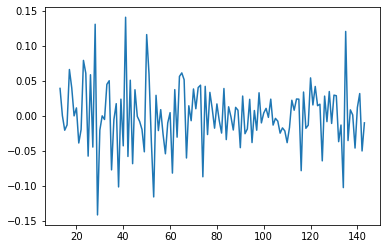

In [8]:
Passengers_sdiff2 = Passengers_sdiff.diff()
Passengers_sdiff2.plot()

## Time Series Data

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Time%20Series%20Data.ipynb

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

Ice Cream Production Data

In [112]:
#read data
df_ice_cream = pd.read_csv('data/ice_cream.csv')

In [21]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


コラム名を、わかりやすい名称に変更

In [117]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

dataコラムを、datetime型に変換（スライスなどが簡単になる）

In [118]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

dateをインデクスに設定

In [119]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

datetime型を使った、スライスが可能になり、2010-1-1以降のデータを得る

In [120]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [121]:
#show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


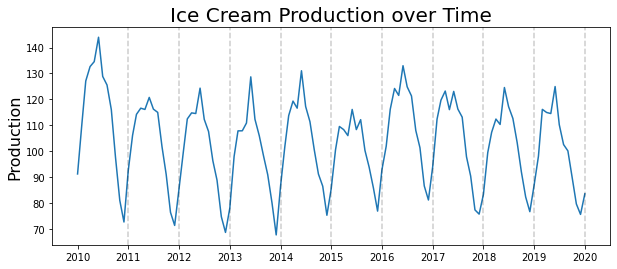

In [122]:

plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### ACF
ACFを測ってみる、長期の傾向を測る。

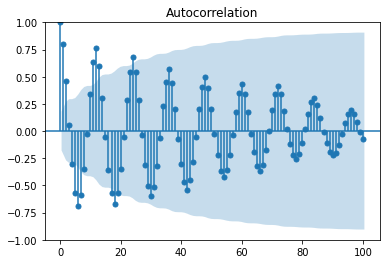

In [123]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

長期の傾向が、減衰しているようなので、ここはARモデルを採用するほうがよさそうだ。
Based on decaying ACF, we are likely dealing with an Auto Regressive process


ではARのラグは何を指定すればよいのか？そこでPACFを検査する

### PACF

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


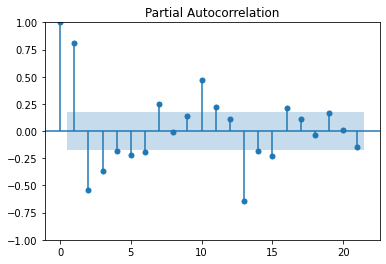

In [124]:
pacf_plot = plot_pacf(df_ice_cream.production)

PACFの結果から、モデルとしては、ARモデルで、ラグが lags=1,2,3,10,13 のモデルが良いと思われる。

## 季節性分解
季節性を分解してみましょう

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
import io
import requests
import statsmodels.api as sm

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
passengers = content['#Passengers']

In [32]:
pd_content = content.copy()
pd_content['Month'] = pd.to_datetime(pd_content['Month'], infer_datetime_format=True)
pd_content.index = pd_content.Month

<AxesSubplot:xlabel='Month'>

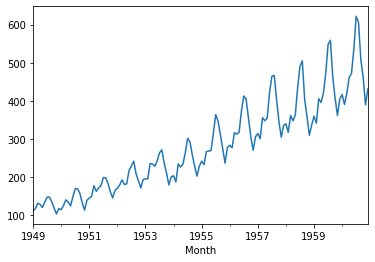

In [33]:
pd_content['#Passengers'].plot()

In [34]:
df_passenger = pd.DataFrame(content['#Passengers'].values.astype(int), 
 #                           pd.DatetimeIndex(start='1949-01',
                            pd.date_range(start='1949-01',
                                             periods=len(content['#Passengers']), 
                                             freq='M'))

In [35]:
df_passenger.head()

,0
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


### 加法モデルに基づく季節性分解

In [37]:
#ts = sm.tsa.seasonal_decompose(df_passenger.values, freq=12)
ts = sm.tsa.seasonal_decompose(df_passenger, model='additive',extrapolate_trend='freq')

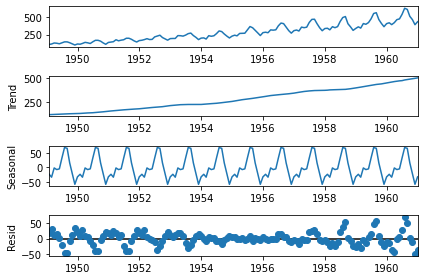

In [38]:
ts.plot();

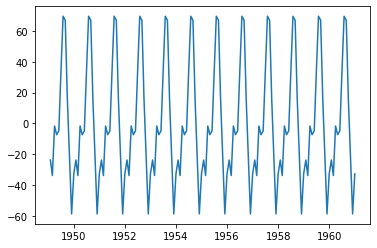

In [39]:
# 季節変動
plt.plot(ts.seasonal)

### 乗法モデルによる季節分解

In [40]:
ts2 = sm.tsa.seasonal_decompose(df_passenger, model='multiplicative',extrapolate_trend='freq')

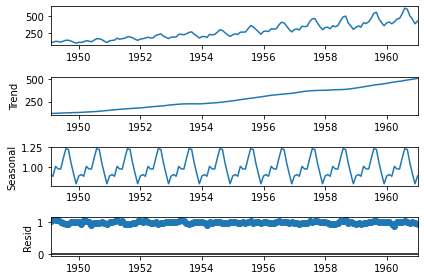

In [41]:
ts2.plot();

## 移動平均
- 　データは以下から入手
- https://www.mizuhobank.co.jp/market/index.html

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [46]:
# エクセル向けデータで文字コードshift-jis、最初の行は日本語のコラム名なので、飛ばして1行目の英語のコラム名から読む
df_historical = pd.read_csv("data/m_quote.csv",encoding="shift-jis",header=1)
df_historical.head()

,Unnamed: 0,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,...,HUF,CZK,PLN,RUB,TRY,IDR(100).1,CNY.1,MYR.1,KRW(100).1,TWD
0,2002/4/30,131.15,189.01,115.97,82.83,79.13,12.73,15.61,15.20,70.24,...,*****,*****,*****,NaN,NaN,1.39,15.84,*****,9.99,3.77
1,2002/5/31,126.44,184.56,115.88,81.58,79.60,12.57,15.59,15.43,69.58,...,*****,*****,*****,NaN,NaN,1.41,15.28,*****,10.10,3.68
2,2002/6/28,123.53,183.00,117.83,80.64,80.09,12.94,15.86,15.92,70.29,...,*****,*****,*****,NaN,NaN,1.44,14.93,*****,10.20,3.66
3,2002/7/31,118.05,183.64,117.23,76.52,80.16,12.67,15.79,15.83,65.42,...,*****,*****,*****,NaN,NaN,1.34,14.26,*****,9.98,3.56
4,2002/8/30,119.08,183.14,116.45,75.85,79.60,12.59,15.69,15.68,64.47,...,*****,*****,*****,NaN,NaN,1.35,14.39,*****,9.97,3.53


<AxesSubplot:>

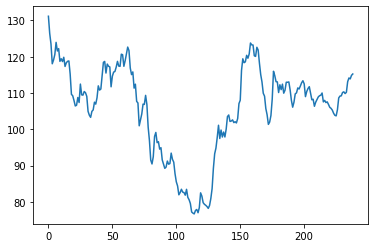

In [47]:
df_historical.USD.plot()

<AxesSubplot:>

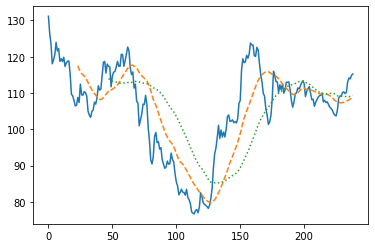

In [48]:
df_historical.USD.plot()
df_historical.USD.rolling(window=24).mean().plot(style='--')
df_historical.USD.rolling(48).mean().plot(style=':')

## 時間依存性の発見

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [50]:
import io
import requests

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
passengers = content['#Passengers']

In [51]:
import statsmodels.api as sm

# 自己相関
p_acf = sm.tsa.stattools.acf(passengers)

# 偏自己相関
p_pacf = sm.tsa.stattools.pacf(passengers, method='ols')
p_acf, p_pacf

(array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
        0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
        0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
        0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
        0.4416288 , 0.45722376]),
 array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
         0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
         0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
         0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
        -0.04046447,  0.13739883]))

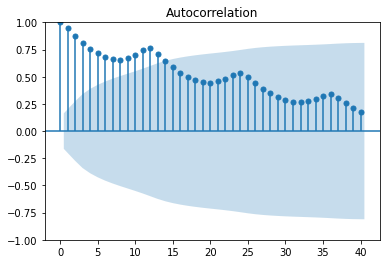

In [20]:
sm.graphics.tsa.plot_acf(passengers, lags=40);

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


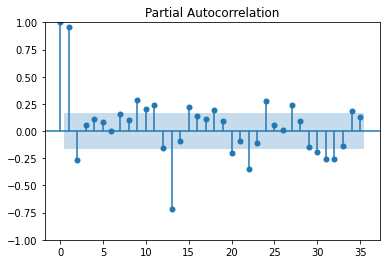

In [52]:
sm.graphics.tsa.plot_pacf(passengers, lags=35);

### 定常性、
df_historical.USDをまた使います

<AxesSubplot:>

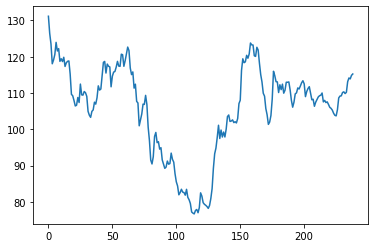

In [53]:
df_historical.USD.plot()

In [54]:
df_logdiff_USD = (1 + df_historical.USD.pct_change()).apply(np.log)

In [55]:
df_historical.USD.div(df_historical.USD.shift(1)) - 1

0           NaN
1     -0.035913
2     -0.023015
3     -0.044362
4      0.008725
         ...   
234    0.026593
235    0.009106
236   -0.002278
237    0.008606
238    0.003221
Name: USD, Length: 239, dtype: float64

In [25]:
df_historical.USD.pct_change()

0           NaN
1     -0.035913
2     -0.023015
3     -0.044362
4      0.008725
         ...   
234    0.026593
235    0.009106
236   -0.002278
237    0.008606
238    0.003221
Name: USD, Length: 239, dtype: float64

<AxesSubplot:>

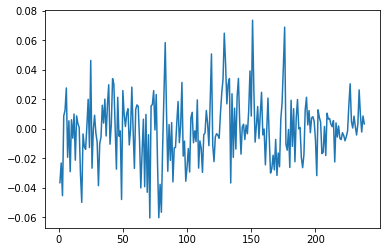

In [56]:
df_logdiff_USD.plot()

## ARモデル

 出典：[島田]島田：時系列解析、共立出版

2003年から2013年までの月ごとのアイスクリームの家庭平均消費額データを使う

ARモデルは定常時系列d－多にした適用できないため、定常過程であるかを検定(ADF検定)しながら、階差をとりつつ、定常にした上でARによりモデル化する。

In [57]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [58]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa import ar_model

In [61]:
# アイスクリーム消費データ
df_ice = pd.read_csv('data/icecream2.csv')

<AxesSubplot:>

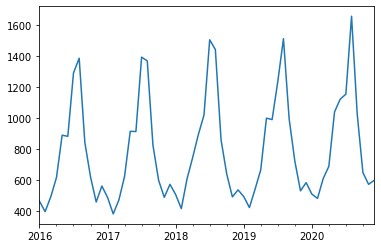

In [62]:
# 月ごとの家庭平均消費額のみを抽出し
# インデックスを2003年1月からの月ごとにする
y = pd.Series(df_ice.expenditure_yen.values, 
              index=pd.date_range('2016-1', periods=len(df_ice), freq='M'))
y.plot()

ここで、adfuller()関数を使って、ADF検定を行う、

regression=回帰モデルの定数とトレンドを指定する。
- regression = 'c'    定数のみ
- regression = 'ct'    定数とトレンド
- regression = 'ctt'    定数と１次、２次のトレンド
- regression = 'nt'    定数もトレンドもなし

回帰モデルの設定の元、もっともPt値の低くなった組合せを返す。

返り値：2番目がP値である。

- adf
  - ADF検定の統計量
- pvalue
  - 検定のP値
- usedlag
-   モデルに採用されたラグの値
- nobs
  - 回帰に使われたデータの個数
- critical values
  - 検定の1,5,10%点の値
- icbest
  - autolagがNoneでない場合、情報量の最大値を返す。
- resstore
  - 検定と回帰の結果のインスタンス

In [64]:
# トレンド項あり(2次まで)，定数項ありの場合
ctt = stattools.adfuller(y[:50], regression="ctt")
# トレンド項あり(1次)，定数項ありの場合
ct = stattools.adfuller(y[:50], regression="ct")
# トレンド項なし，定数項ありの場合
c = stattools.adfuller(y[:50], regression="c")
# トレンド項なし，定数項なしの場合
nc = stattools.adfuller(y[:50], regression="n")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-1.632103929718587, 0.9225814258272907, 11, 38, {'1%': -4.706975782912961, '5%': -3.9986083773144774, '10%': -3.654389089517422}, 449.6683173557131)
ct:
(-1.4043373341701342, 0.8596347593778406, 11, 38, {'1%': -4.219141325995043, '5%': -3.5331113660883506, '10%': -3.1982181075958596}, 448.83576949640724)
c:
(-0.6419017032811434, 0.8612301439919721, 11, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 449.21670697770713)
nc:
(1.5151013822013237, 0.9679527147820244, 11, 38, {'1%': -2.6270886149584487, '5%': -1.9498297383000438, '10%': -1.6112477883073333}, 447.9340526229006)


いづれの場合もP値が高く、定常過程であることが棄却された。

pandasのdiff()関数を使い、1次階差をとってみると、トレンドが消えたように見える

diffをとると端にNAが生じるので、dropna()していることに注意。

<AxesSubplot:>

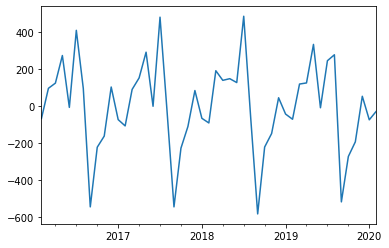

In [143]:
y_diff = y.diff()[:50].dropna()
y_diff.plot()

で0タの数は減っている。

In [66]:
y_diff.count()

49

再び定常性の検定を行う。

In [144]:
ctt = stattools.adfuller(y_diff, regression="ctt")
ct = stattools.adfuller(y_diff, regression="ct")
c = stattools.adfuller(y_diff, regression="c")
nc = stattools.adfuller(y_diff, regression="n")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-10.39037569927393, 5.562010710668808e-16, 10, 38, {'1%': -4.706975782912961, '5%': -3.9986083773144774, '10%': -3.654389089517422}, 441.5685348478122)
ct:
(-10.61099969294781, 1.274035163563458e-16, 10, 38, {'1%': -4.219141325995043, '5%': -3.5331113660883506, '10%': -3.1982181075958596}, 439.592686904717)
c:
(-10.823472821329347, 1.7811366428115545e-19, 10, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 437.60758618043326)
nc:
(-10.453590052108291, 1.029873286577325e-18, 10, 38, {'1%': -2.6270886149584487, '5%': -1.9498297383000438, '10%': -1.6112477883073333}, 438.6562461856374)


どの回帰モデルをつかっても、P値が十分低い、つまり定常性があるといえる

<AxesSubplot:>

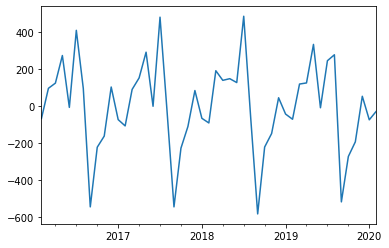

In [154]:
y_diff.plot()

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


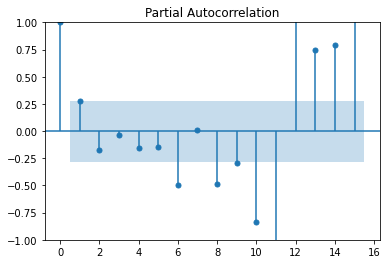

In [155]:
# 偏自己相関
tsaplots.plot_pacf(y_diff, lags=15);

lagを11までときめて実行

In [168]:
model = ar_model.AutoReg(y_diff,lags=11)
result=model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   49
Model:                    AutoReg(11)   Log Likelihood                -211.919
Method:               Conditional MLE   S.D. of innovations             63.936
Date:                Mon, 09 May 2022   AIC                            449.838
Time:                        22:02:17   BIC                            471.127
Sample:                    01-31-2017   HQIC                           457.412
                         - 02-29-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5490     10.510      1.860      0.063      -1.050      40.148
y.L1          -0.6700      0.119     -5.611      0.000      -0.904      -0.436
y.L2          -0.9421      0.066    -14.268      0.0

In [169]:
result.params

const    19.548960
y.L1     -0.669952
y.L2     -0.942065
y.L3     -0.708279
y.L4     -0.893058
y.L5     -0.723589
y.L6     -0.943044
y.L7     -0.695630
y.L8     -0.941804
y.L9     -0.734198
y.L10    -0.872845
y.L11    -0.716219
dtype: float64

<BarContainer object of 38 artists>

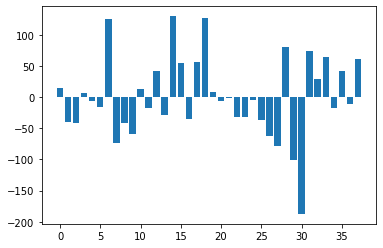

In [170]:
res11= result.resid
plt.bar(range(len(res11)),res11)

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


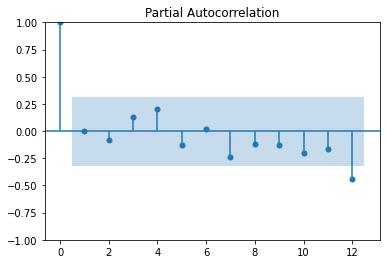

In [171]:
# 偏自己相関
tsaplots.plot_pacf(res11, lags=12);

In [172]:
result.fittedvalues

2017-01-31    -87.316138
2017-02-28    -66.879956
2017-03-31    132.138986
2017-04-30    145.597485
2017-05-31    297.195293
2017-06-30     14.221743
2017-07-31    355.011708
2017-08-31     48.952962
2017-09-30   -502.631033
2017-10-31   -168.488602
2017-11-30   -123.251997
2017-12-31    101.468186
2018-01-31   -108.680032
2018-02-28    -62.211822
2018-03-31     61.202947
2018-04-30     83.775601
2018-05-31    182.460530
2018-06-30     70.852512
2018-07-31    357.947450
2018-08-31    -71.047776
2018-09-30   -575.586340
2018-10-31   -219.536164
2018-11-30   -116.407560
2018-12-31     77.275742
2019-01-31    -37.997214
2019-02-28    -35.078691
2019-03-31    181.760583
2019-04-30    203.736300
2019-05-31    253.226423
2019-06-30     92.513962
2019-07-31    432.446815
2019-08-31    203.179760
2019-09-30   -546.204307
2019-10-31   -336.983401
2019-11-30   -175.288605
2019-12-31     11.132386
2020-01-31    -63.408741
2020-02-29    -89.098996
Freq: M, dtype: float64

In [173]:
y_pred=result.predict()

<AxesSubplot:>

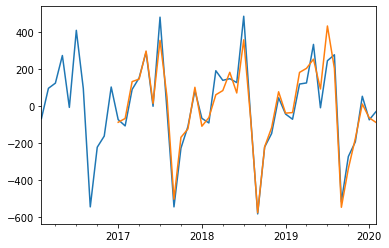

In [174]:
y_diff.plot()
y_pred.plot()

In [175]:
#model = ar_model.AR(y_diff)
for i in range(20):
    results = ar_model.AutoReg(y_diff,lags=i+1).fit() 
    print('lag = ', i+1, 'aic : ', results.aic)

lag =  1 aic :  665.518429751334
lag =  2 aic :  653.1716811394194
lag =  3 aic :  642.2572023370839
lag =  4 aic :  629.3142929061039
lag =  5 aic :  617.70415905039
lag =  6 aic :  588.5788764936625
lag =  7 aic :  578.1805138667553
lag =  8 aic :  551.7255500894247
lag =  9 aic :  539.2899615712902
lag =  10 aic :  483.858076627042
lag =  11 aic :  449.83789928154135
lag =  12 aic :  441.60600035885085
lag =  13 aic :  432.34563926688173
lag =  14 aic :  421.25128596699784
lag =  15 aic :  412.9379262933589
lag =  16 aic :  404.619048070208
lag =  17 aic :  396.41606680412815
lag =  18 aic :  379.5075077299903
lag =  19 aic :  367.0797607591189
lag =  20 aic :  357.65068417020495


In [164]:
#model = ar_model.AutoReg(y_diff)
#for i in range(20):
#    results = model.fit(maxlag=i+1)
#    print('lag = ', i+1, 'aic : ', results.aic)

ここから、これを参考　https://note.com/yiida/n/n6210246ec5b0

In [176]:
# 次数の推定
mod = ar_model.ar_select_order(y_diff, glob=True,maxlag=13)
mod.ar_lags

[12]

In [166]:
# lags を 1 から 12 に変更
ar_model_lag12 = ar_model.AutoReg(y_diff, lags=12)
# モデルの当てはめ
ar_model_lag12 = ar_model_lag12.fit()
# 予測
predict_lag12 = ar_model_lag12.predict()

<AxesSubplot:>

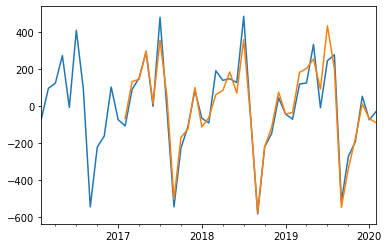

In [177]:
y_diff.plot()
predict_lag12.plot()

## ARMAモデル

In [86]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [87]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

ここｋら、
https://analytics-note.xyz/time-series/statsmodels-arma/

In [88]:
# 次数の推定
print(sm.tsa.arma_order_select_ic(y_diff, max_ar=5, max_ma=5, ic='aic'))

c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization fail

{'aic':             0           1           2           3           4           5
0  680.141999  677.306285  678.058032  676.295869  670.634659  671.323904
1  678.404569  675.704916  672.837532  674.768796  671.378300  673.339074
2  679.041958  670.468412  672.927471  673.943736  670.983722  662.155028
3  680.992538  671.638723  671.154448  656.034950  667.224828  673.876807
4  681.961083  679.305304  668.463907  665.916660  651.376832  654.189121
5  683.166195  665.965354  669.441267  657.406124  653.500088  657.133700, 'aic_min_order': (4, 4)}


c:\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'aic_min_order': (4, 4)}　とでているのでARMA(4,4)でモデル化してみる

注ここでは、ARIMA(4,0,4)で代替

In [140]:
# ARMAモデルの作成と推定
arma_model = sm.tsa.ARIMA(y_diff, order=(4, 0,4))
result = arma_model.fit()

c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [141]:
#結果の表示
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   49
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -315.688
Date:                Mon, 09 May 2022   AIC                            651.377
Time:                        21:44:20   BIC                            670.295
Sample:                    02-29-2016   HQIC                           658.554
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0230      0.814      2.484      0.013       0.427       3.619
ar.L1         -0.0440      0.176     -0.250      0.802      -0.388       0.300
ar.L2          0.8617      0.118      7.282      0.0

<AxesSubplot:>

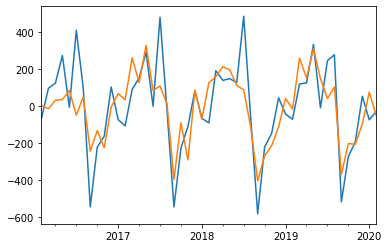

In [142]:
y_pred=result.predict()
y_diff.plot()
y_pred.plot()

なんとなく季節性に弱い感じです。

## ホワイトノイズ

<AxesSubplot:title={'center':'Random White Noise'}>

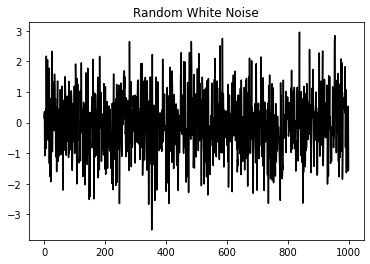

In [39]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')

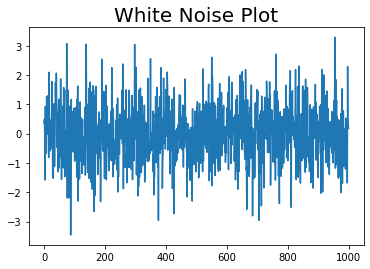

In [40]:
# Declare
white_noise = np.random.randn(1000)

# Plot
plt.title('White Noise Plot', size=20)
plt.plot(np.arange(len(white_noise)), white_noise);

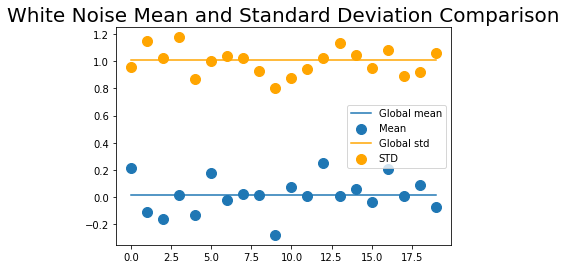

In [41]:
# Split into an arbitraty number of chunks
white_noise_chunks = np.split(white_noise, 20)
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [white_noise.mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [white_noise.std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend()

## ARIMAによる解析の例


In [89]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


In [196]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))

<AxesSubplot:xlabel='Month'>

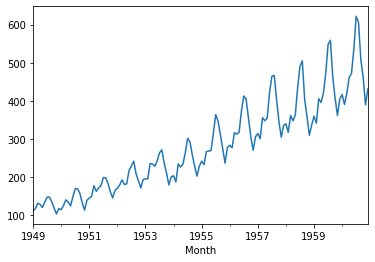

In [197]:
df_content = content.copy()
df_content['Month'] = pd.to_datetime(df_content['Month'], 
                                     infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')
y.plot()

In [200]:
len(y)

144

In [198]:
# yは上のコードで取得した月ごとの旅客機の乗客数データ
y120 = y[:120]

In [92]:
y120.values

array([ 464,  397,  493,  617,  890,  883, 1292, 1387,  843,  621,  459,
        562,  489,  382,  472,  624,  915,  914, 1394, 1370,  826,  599,
        489,  573,  507,  416,  607,  746,  894, 1021, 1506, 1443,  861,
        640,  492,  537,  494,  423,  542,  667, 1000,  991, 1236, 1513,
        996,  724,  531,  584,  510,  482,  610,  689, 1040, 1123, 1155,
       1658, 1025,  649,  573,  599], dtype=int64)

c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<BarContainer object of 119 artists>

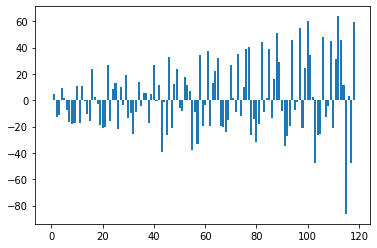

In [201]:
# 階差をとらないモデル(p=3,d=0,q=2)
model_d0 =sm.tsa.arima.ARIMA(y120.values, order=(3, 0, 2))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

In [202]:
len(res_d0[1:])

119

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


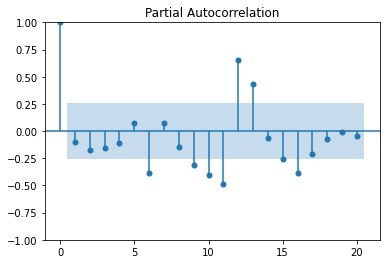

In [109]:
# 偏自己相関
tsaplots.plot_pacf(res_d0[1:], lags=20);

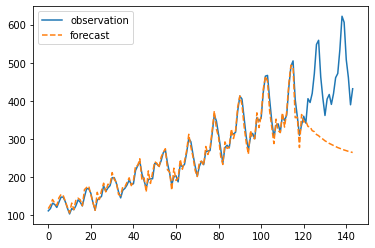

In [204]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)), 
         '--', label='forecast')
plt.legend()

<BarContainer object of 119 artists>

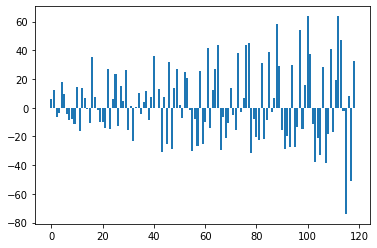

In [205]:
# 階差をとらないモデル(p=4,d=1,q=1)
model_d0 =sm.tsa.arima.ARIMA(y120.values, order=(4, 1, 1))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


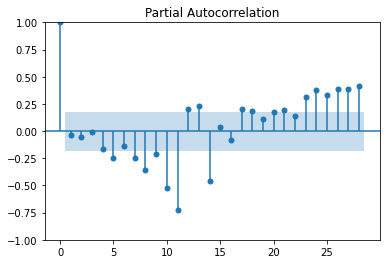

In [206]:
# 偏自己相関
tsaplots.plot_pacf(res_d0[1:], lags=28);

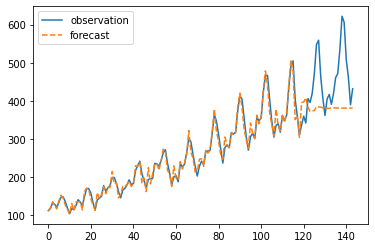

In [207]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)), 
         '--', label='forecast')
plt.legend()

## SARIMAX

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p, d, q, sp, sd, sq = 2, 1, 2, 1, 1, 1
seasonal = 12

# SARIMAX(p=2,d=1,q=2; P=1,D=1,Q=1,s=12)モデルの当てはめ
result = SARIMAX(
    y120, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result.summary())

c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -343.463
Date:                              Tue, 10 May 2022   AIC                            700.926
Time:                                      05:38:47   BIC                            718.579
Sample:                                  01-01-1949   HQIC                           708.051
                                       - 12-01-1958                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2791      0.573      0.487      0.626      -0.844       1.402
ar.L2          0.46

<BarContainer object of 120 artists>

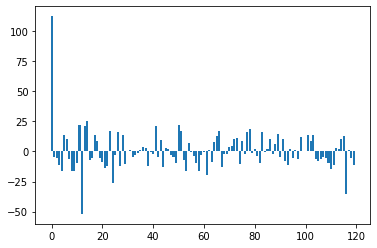

In [209]:
# 残差の抽出
res = result.resid
# 残差の出力
plt.bar(range(len(res)), res)

c:\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


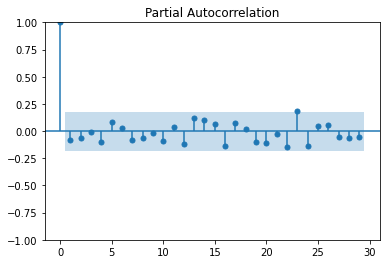

In [211]:
# 偏自己相関
tsaplots.plot_pacf(res, lags=29);
# ランダムウォーク過程のため自己相関はないことが確認できた

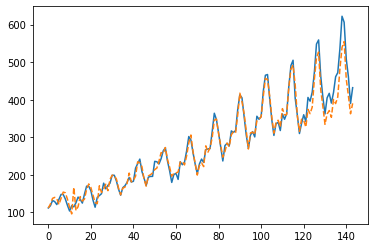

In [212]:
# 将来予測
plt.plot(y.values, label="observation")
plt.plot(np.hstack([y120[0], 
                    result.fittedvalues[1:], 
                    result.forecast(24)]), 
         '--', label="forecast")

### VARモデル

2変量のVARモデルにしたがうデータから、Pythonを使ってモデルの係数を推定する方法を紹介します。
答え合わせをしたいので、使うデータは特定のVARモデルから生成します。

https://analytics-note.xyz/time-series/statsmodels-var-fit/

$$

\left\{\begin{matrix}\

y_{1t} &=& 2+ 0.5 y_{1,t-1}+ 0.4 y_{2,t-1}+\varepsilon_{1t},\\\

y_{2t} &=& -3 + 0.6 y_{1,t-1}+ 0.3 y_{2,t-1}+\varepsilon_{2t}\

\end{matrix}\

\right.\

\left(\begin{matrix}\varepsilon_{1t}\\\varepsilon_{2t}\end{matrix}\right)\sim W.N.(\mathbf{\Sigma})
$$

[[3.69377224 1.19450655]
 [1.19450655 1.03259388]]


c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAK

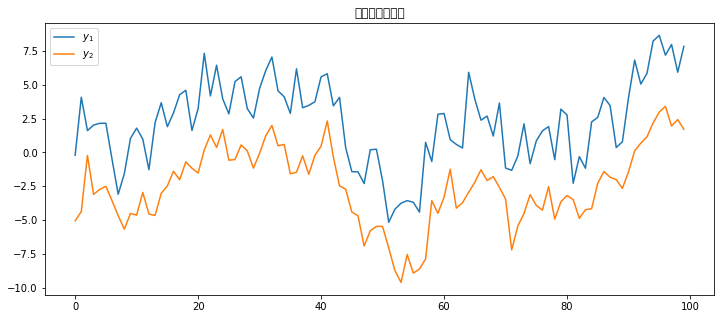

In [184]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.array([0, 0])
cov = np.array([[4, 1.2], [1.2, 1]])

# 少し長めの系列でデータを生成する。
data = np.zeros([110, 2])
epsilons = np.random.multivariate_normal(mean, cov, size=110)
print(np.cov(epsilons, rowvar=False))
"""
[[3.96508657 1.1917421 ]
 [1.1917421  1.01758275]]
"""

for i in range(1, 110):
    data[i, 0] = 2 + 0.5*data[i-1, 0] + 0.4*data[i-1, 1] + epsilons[i, 0]
    data[i, 1] = -3 + 0.6*data[i-1, 0] + 0.3*data[i-1, 1] + epsilons[i, 1]

# 初めの10項を切り捨てる
data = data[10:]
# data.shape == (100, 2)

fig = plt.figure(figsize=(12, 5), facecolor="w")
ax = fig.add_subplot(111)
ax.plot(data[:, 0], label="$y_1$")
ax.plot(data[:, 1], label="$y_2$")
ax.set_title("サンプルデータ")
plt.legend()
plt.show()

ここから、VARモデルに当てはめます。

In [191]:
data

array([[-0.20087952, -5.06553802],
       [ 4.08813957, -4.3675368 ],
       [ 1.62073654, -0.21816043],
       [ 2.02875456, -3.10552605],
       [ 2.16013414, -2.73112556],
       [ 2.16441035, -2.505942  ],
       [-0.50252339, -3.57295717],
       [-3.09257849, -4.67379546],
       [-1.56726144, -5.67899243],
       [ 1.04402069, -4.51119956],
       [ 1.80330865, -4.64024293],
       [ 0.9916419 , -2.95515639],
       [-1.26816617, -4.55119354],
       [ 2.20257427, -4.6626395 ],
       [ 3.68250626, -3.02118132],
       [ 1.91000494, -2.47309543],
       [ 2.93170541, -1.39228028],
       [ 4.27861199, -2.02277005],
       [ 4.60710265, -0.69491967],
       [ 1.62995814, -1.16734408],
       [ 3.24403121, -1.51520998],
       [ 7.34155053,  0.18745003],
       [ 4.18688775,  1.300668  ],
       [ 6.46147171,  0.3737745 ],
       [ 3.97951003,  1.70454902],
       [ 2.8597063 , -0.57069937],
       [ 5.25260473, -0.52071729],
       [ 5.60758265,  0.56407612],
       [ 3.2477267 ,

In [194]:
from statsmodels.tsa.api import VAR
model = VAR(data)
result = model.fit(maxlags=1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, May, 2022
Time:                     22:14:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.09173
Nobs:                     99.0000    HQIC:                  0.998088
Log likelihood:          -321.205    FPE:                    2.54591
AIC:                     0.934452    Det(Omega_mle):         2.39835
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.418448         0.639525            3.782           0.000
L1.y1         0.422835         0.127770            3.309           0.001
L1.y2         0.427516         0.138984            3.076           0.002

Results for equation 

In [195]:
result.params

array([[ 2.41844776, -3.00736895],
       [ 0.42283529,  0.61058389],
       [ 0.42751631,  0.30985015]])

VARモデルに当てはめた結果

$$
\left\{\begin{matrix}\

y_{1t} &=& 2.42+ 0.42 y_{1,t-1}+ 0.43 y_{2,t-1}\\\

y_{2t} &=& -3.01 + 0.61 y_{1,t-1}+ 0.31 y_{2,t-1}\

\end{matrix}\

\right.\
$$